In [45]:
import pandas as pd

chunk_size = 5000000  # Размер чанка можно настроить в зависимости от объема памяти

# Чтение файла по частям
chunks = pd.read_csv('/kaggle/input/timestamp/train.csv', chunksize=chunk_size)

for chunk in chunks:
    chunk1 = chunk
    break 

In [46]:
from catboost import  CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from tsfresh import extract_relevant_features
from tsfresh.examples.robot_execution_failures import load_robot_execution_failures
import geopandas as gpd
import numpy as np
import tqdm
import datetime
import requests
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.metrics import mean_squared_error

In [3]:
!pip install meteostat

In [18]:
train = train.drop(columns=['fare_amount','key', 'index'])
y = chunk1['fare_amount']

In [19]:
# фича разницы между координатами
# train['lat_diff'] = (train['pickup_latitude'] - train['dropoff_latitude']) * 1000
# train['lon_diff'] = (train['pickup_longitude'] - train['dropoff_longitude']) * 1000

In [63]:
train_data, test, y_train, y_test = train_test_split(dataset, y, test_size=0.05)

BASELINE

In [64]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.2, random_state=42)

In [65]:
X_train.dtypes

pickup_datetime          datetime64[ns]
pickup_longitude                float16
pickup_latitude                 float16
dropoff_longitude               float16
dropoff_latitude                float16
distance_geo_km                 float64
manhattan_distance_km           float64
time_of_day                      object
dtype: object

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

def train_and_compare_models(X, y):
    """
    Обучает три модели (LightGBM, XGBoost и CatBoost) и сравнивает их по трем метрикам.

    :param X: Признаки (DataFrame или NumPy массив)
    :param y: Целевая переменная (Series или NumPy массив)
    :return: DataFrame с результатами сравнения моделей по метрикам
    """
    
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Инициализация моделей
    models = {
        'LightGBM': lgb.LGBMClassifier(),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(silent=True)
    }

    # Словарь для хранения результатов
    results = {}

    # Обучение и оценка моделей
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для ROC AUC

        # Вычисляем метрики
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        # Для RMSE используем вероятности предсказаний
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))

        # Сохраняем результаты в словаре
        results[name] = {
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'RMSE': rmse
        }

    # Преобразуем результаты в DataFrame для удобного отображения
    results_df = pd.DataFrame(results).T

    return results_df

# Пример использования функции
# Предположим, что у вас есть DataFrame X с признаками и Series y с целевой переменной.
# results = train_and_compare_models(X, y)
# print(results)

In [67]:
clf = CatBoostRegressor(
    random_seed=42,
    early_stopping_rounds=100,  # Остановка обучения при отсутствии улучшений
    eval_metric='RMSE',          # Явно указываем метрику RMSE
    cat_features=['time_of_day']
)

# Обучение модели
clf.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),  # Валидационный набор данных
    verbose=10,                  # Вывод информации о процессе обучения
    use_best_model=True          # Использовать лучшую модель
)

Learning rate set to 0.185023
0:	learn: 8.5066845	test: 8.5240818	best: 8.5240818 (0)	total: 1.39s	remaining: 23m 8s
10:	learn: 5.1529952	test: 5.1903288	best: 5.1903288 (10)	total: 11.5s	remaining: 17m 17s
20:	learn: 4.8910488	test: 4.9454479	best: 4.9454479 (20)	total: 21.3s	remaining: 16m 30s
30:	learn: 4.8129390	test: 4.8777402	best: 4.8777402 (30)	total: 29.8s	remaining: 15m 30s
40:	learn: 4.7719315	test: 4.8468691	best: 4.8468691 (40)	total: 38.6s	remaining: 15m 3s
50:	learn: 4.7397949	test: 4.8206934	best: 4.8206934 (50)	total: 47.3s	remaining: 14m 39s
60:	learn: 4.7240841	test: 4.8098710	best: 4.8098710 (60)	total: 56.3s	remaining: 14m 27s
70:	learn: 4.7070073	test: 4.7959035	best: 4.7959035 (70)	total: 1m 5s	remaining: 14m 13s
80:	learn: 4.6969401	test: 4.7888562	best: 4.7888562 (80)	total: 1m 13s	remaining: 13m 57s
90:	learn: 4.6851346	test: 4.7800177	best: 4.7800177 (90)	total: 1m 23s	remaining: 13m 50s
100:	learn: 4.6722915	test: 4.7699514	best: 4.7699514 (100)	total: 1m 32

In [68]:
y_pred = pd.DataFrame(clf.predict(test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

4.618857181289532

In [ ]:
1) 4.84 4.65
2) 

In [ ]:
train

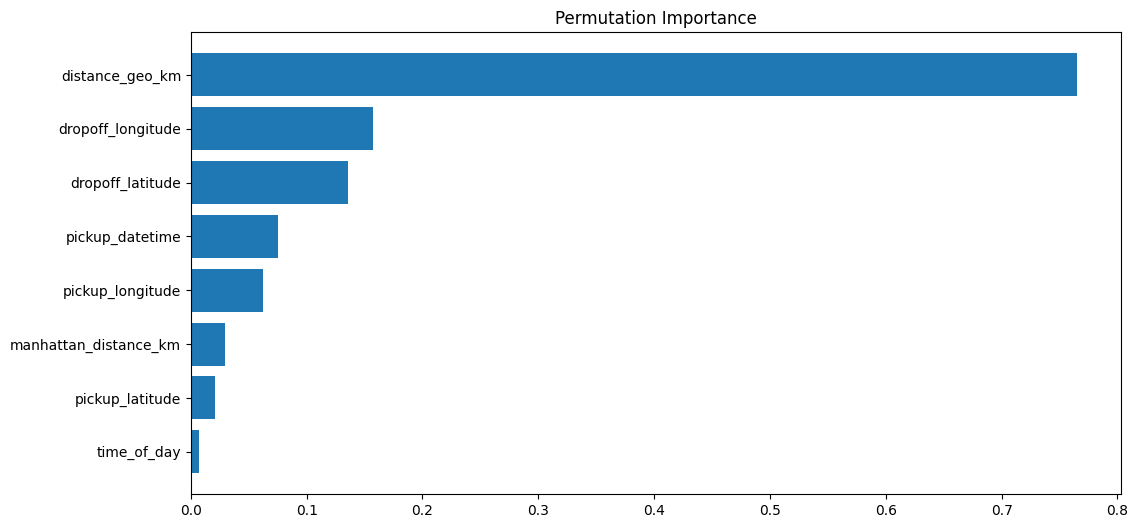

In [69]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(clf, test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test.columns)[sorted_idx])
plt.title('Permutation Importance');

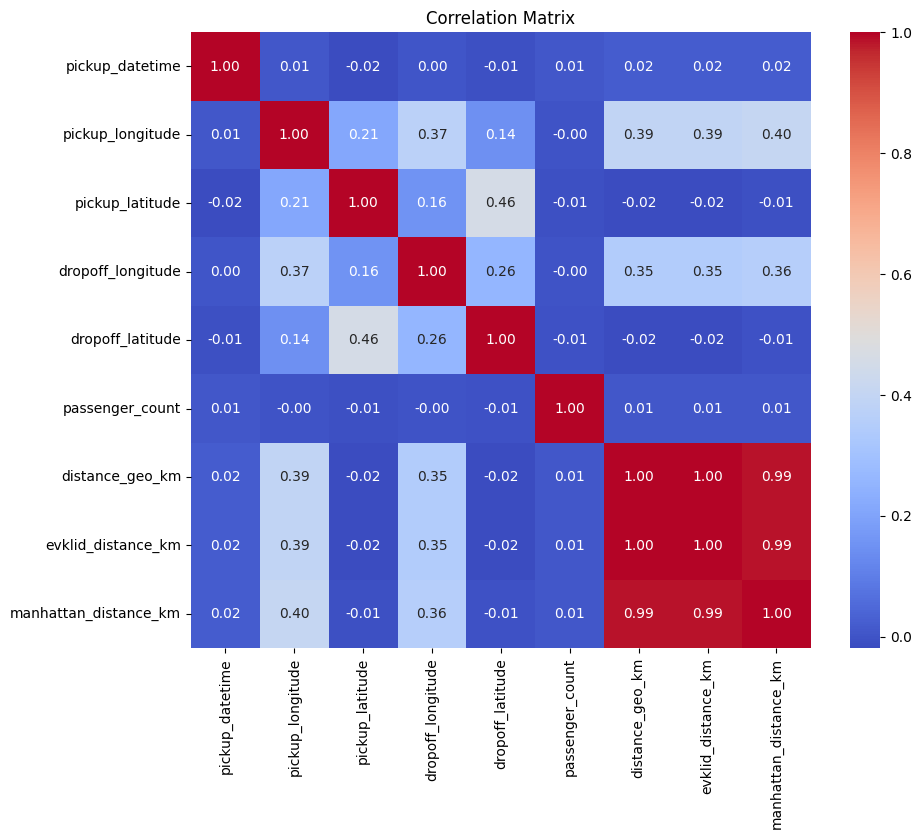

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Рассчитываем корреляционную матрицу
correlation_matrix = dataset.corr()

# Строим тепловую карту корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Генерируем данные с даты

## CLEARING DATA

In [47]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ Проходит по всем столбцам DataFrame и изменяет тип данных
        для уменьшения использования памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        
        # Пропускаем столбцы с типами object, category и datetime
        if col_type not in ['object', 'category', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Проверка на float
                if str(col_type)[:5] == 'float':
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [48]:
def clean_df(df):
    criteria = (
        " 0 < fare_amount <= 500"
        " and 0 < passenger_count <= 6 "
        " and -75 <= pickup_longitude <= -72 "
        " and -75 <= dropoff_longitude <= -72 "
        " and 40 <= pickup_latitude <= 42 "
        " and 40 <= dropoff_latitude <= 42 "
    )
    df = (df
          .dropna()
          .query(criteria)
          .reset_index()       
         )
    return df

In [49]:
train = clean_df(chunk1)
train = reduce_mem_usage(train)

Memory usage of dataframe is 334.89 MB
Memory usage after optimization is: 144.19 MB
Decreased by 56.9%


In [50]:
train

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.500000,2009-06-15 17:26:21 UTC,-73.8750,40.71875,-73.8125,40.71875,1
1,1,2010-01-05 16:52:16.0000002,16.906250,2010-01-05 16:52:16 UTC,-74.0000,40.71875,-74.0000,40.78125,1
2,2,2011-08-18 00:35:00.00000049,5.699219,2011-08-18 00:35:00 UTC,-74.0000,40.75000,-74.0000,40.75000,2
3,3,2012-04-21 04:30:42.0000001,7.699219,2012-04-21 04:30:42 UTC,-74.0000,40.71875,-74.0000,40.75000,1
4,4,2010-03-09 07:51:00.000000135,5.300781,2010-03-09 07:51:00 UTC,-73.9375,40.78125,-73.9375,40.78125,1
...,...,...,...,...,...,...,...,...,...
4877131,4999995,2011-01-24 21:33:44.0000003,16.500000,2011-01-24 21:33:44 UTC,-74.0000,40.71875,-74.0000,40.81250,1
4877132,4999996,2013-10-11 12:12:00.000000118,9.000000,2013-10-11 12:12:00 UTC,-74.0000,40.75000,-74.0000,40.71875,2
4877133,4999997,2014-12-06 23:04:28.0000002,10.500000,2014-12-06 23:04:28 UTC,-74.0000,40.75000,-74.0000,40.78125,2
4877134,4999998,2015-05-30 19:01:24.0000004,10.000000,2015-05-30 19:01:24 UTC,-73.9375,40.75000,-74.0000,40.75000,1


In [51]:
train['pickup_datetime'] = train['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x[:-4], '%Y-%m-%d %H:%M:%S'))

In [16]:
# from shapely.geometry import Point

# # Координаты центра Нью-Йорка
# nyc_center = Point(-74.0060, 40.7128)

# # Преобразование данных в GeoDataFrame с точками pickup и dropoff
# train['pickup_point'] = train.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
# train['dropoff_point'] = train.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# # Создаем GeoDataFrame
# gdf = gpd.GeoDataFrame(train, geometry='pickup_point', crs='EPSG:2263') 

# # Преобразование системы координат в метрическую (например, UTM)
# gdf = gdf.to_crs('EPSG:2263')  # Пример UTM зоны, выбирайте соответствующую зоне Нью-Йорка

# # Также преобразуем центр Нью-Йорка в ту же систему координат
# nyc_center_gdf = gpd.GeoDataFrame(geometry=[nyc_center], crs='EPSG:2263').to_crs(gdf.crs)
# nyc_center_point = nyc_center_gdf.geometry.iloc[0]

# # Расчет расстояний в километрах от точки начала до центра Нью-Йорка
# gdf['start_to_center'] = gdf.distance(nyc_center_point)

# # Переходим к dropoff_point и повторяем расчет
# gdf = gdf.set_geometry('dropoff_point')
# gdf['end_to_center'] = gdf.distance(nyc_center_point)

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [21]:
gdf['start_to_center'] = round(gdf['start_to_center'] * 100, 2)
gdf['end_to_center'] = round(gdf['end_to_center'] * 100, 2)

In [28]:
train['pickup_point'] = train.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
train['dropoff_point'] = train.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [ ]:
pickup_points = gpd.GeoDataFrame(train, geometry=[Point(lon, lat) for lon, lat in zip(train['pickup_longitude'], train['pickup_latitude'])], crs="EPSG:4326")
dropoff_points = gpd.GeoDataFrame(train, geometry=[Point(lon, lat) for lon, lat in zip(train['dropoff_longitude'], train['dropoff_latitude'])], crs="EPSG:4326")

# Преобразование в EPSG:2263
pickup_points = pickup_points.to_crs(epsg=2263)
dropoff_points = dropoff_points.to_crs(epsg=2263)

In [61]:
# Преобразуем данные в проекцию метры (например, для Нью-Йорка используем проекцию EPSG:2263)
pickup_points = pickup_points.to_crs(epsg=2263)
dropoff_points = dropoff_points.to_crs(epsg=2263)

## FEATURE ENGENEERING

In [52]:
import geopandas as gpd
from shapely.geometry import Point

def add_distance_feature(df):
    # Создаем геометрические точки для pickup и dropoff
    df['pickup_point'] = df.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
    df['dropoff_point'] = df.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

    # Создаем GeoDataFrame для pickup и dropoff
    pickup_points = gpd.GeoDataFrame(df, geometry='pickup_point', crs="EPSG:4326")
    dropoff_points = gpd.GeoDataFrame(df, geometry='dropoff_point', crs="EPSG:4326")

    # Преобразуем в EPSG:2263
    pickup_points = pickup_points.to_crs(epsg=2263)
    dropoff_points = dropoff_points.to_crs(epsg=2263)

    # Вычисляем расстояние и добавляем в DataFrame
    df['distance_geo_km'] = round(pickup_points.geometry.distance(dropoff_points.geometry) / 1000, 2)

    return df

# Пример использования функции
train = add_distance_feature(train)

In [53]:
train

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_point,dropoff_point,distance_geo_km
0,0,2009-06-15 17:26:21.0000001,4.500000,2009-06-15 17:26:21,-73.8750,40.71875,-73.8125,40.71875,1,POINT (-73.875 40.71875),POINT (-73.8125 40.71875),17.33
1,1,2010-01-05 16:52:16.0000002,16.906250,2010-01-05 16:52:16,-74.0000,40.71875,-74.0000,40.78125,1,POINT (-74 40.71875),POINT (-74 40.78125),22.77
2,2,2011-08-18 00:35:00.00000049,5.699219,2011-08-18 00:35:00,-74.0000,40.75000,-74.0000,40.75000,2,POINT (-74 40.75),POINT (-74 40.75),0.00
3,3,2012-04-21 04:30:42.0000001,7.699219,2012-04-21 04:30:42,-74.0000,40.71875,-74.0000,40.75000,1,POINT (-74 40.71875),POINT (-74 40.75),11.39
4,4,2010-03-09 07:51:00.000000135,5.300781,2010-03-09 07:51:00,-73.9375,40.78125,-73.9375,40.78125,1,POINT (-73.9375 40.78125),POINT (-73.9375 40.78125),0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
4877131,4999995,2011-01-24 21:33:44.0000003,16.500000,2011-01-24 21:33:44,-74.0000,40.71875,-74.0000,40.81250,1,POINT (-74 40.71875),POINT (-74 40.8125),34.16
4877132,4999996,2013-10-11 12:12:00.000000118,9.000000,2013-10-11 12:12:00,-74.0000,40.75000,-74.0000,40.71875,2,POINT (-74 40.75),POINT (-74 40.71875),11.39
4877133,4999997,2014-12-06 23:04:28.0000002,10.500000,2014-12-06 23:04:28,-74.0000,40.75000,-74.0000,40.78125,2,POINT (-74 40.75),POINT (-74 40.78125),11.39
4877134,4999998,2015-05-30 19:01:24.0000004,10.000000,2015-05-30 19:01:24,-73.9375,40.75000,-74.0000,40.75000,1,POINT (-73.9375 40.75),POINT (-74 40.75),17.32


In [54]:
import numpy as np
import pandas as pd

def add_euclidean_distance_feature(df):
    # Константа для перевода широты в метры
    lat_to_m = 111320  # в метрах

    # Вычисляем среднюю широту для коррекции долготы
    avg_lat = np.radians((df['pickup_latitude'] + df['dropoff_latitude']) / 2)
    lon_to_m = lat_to_m * np.cos(avg_lat)

    # Вычисляем разницу широт и долгот в метрах
    dlat_m = (df['dropoff_latitude'] - df['pickup_latitude']) * lat_to_m
    dlon_m = (df['dropoff_longitude'] - df['pickup_longitude']) * lon_to_m

    # Вычисляем Евклидово расстояние в метрах и добавляем новую колонку с расстоянием в километрах
    df['evklid_distance_km'] = round(np.sqrt(dlat_m**2 + dlon_m**2) / 1000, 2)

    return df

# Пример использования функции
train = add_euclidean_distance_feature(train)

In [56]:
def add_manhattan_distance_feature(df):
    # Вычисляем манхэттенское расстояние в метрах
    manhattan_distance_m = (
        np.abs(df['dropoff_latitude'] - df['pickup_latitude']) * 111320 +  # Разница по широте
        np.abs(df['dropoff_longitude'] - df['pickup_longitude']) * (111320 * np.cos(np.radians((df['pickup_latitude'] + df['dropoff_latitude']) / 2)))  # Разница по долготе
    )
    
    # Добавляем новую колонку с расстоянием в километрах
    df['manhattan_distance_km'] = round(manhattan_distance_m / 1000, 2)

    return df

# Пример использования функции
train = add_manhattan_distance_feature(train)

In [58]:
train = train.drop(columns=['evklid_distance_km', 'pickup_point', 'dropoff_point', 'passenger_count', 'index', 'key'])
y = train['fare_amount']

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_geo_km,manhattan_distance_km
0,4.500000,2009-06-15 17:26:21,-73.8750,40.71875,-73.8125,40.71875,17.33,5.28
1,16.906250,2010-01-05 16:52:16,-74.0000,40.71875,-74.0000,40.78125,22.77,6.96
2,5.699219,2011-08-18 00:35:00,-74.0000,40.75000,-74.0000,40.75000,0.00,0.00
3,7.699219,2012-04-21 04:30:42,-74.0000,40.71875,-74.0000,40.75000,11.39,3.48
4,5.300781,2010-03-09 07:51:00,-73.9375,40.78125,-73.9375,40.78125,0.00,0.00
...,...,...,...,...,...,...,...,...
4877131,16.500000,2011-01-24 21:33:44,-74.0000,40.71875,-74.0000,40.81250,34.16,10.44
4877132,9.000000,2013-10-11 12:12:00,-74.0000,40.75000,-74.0000,40.71875,11.39,3.48
4877133,10.500000,2014-12-06 23:04:28,-74.0000,40.75000,-74.0000,40.78125,11.39,3.48
4877134,10.000000,2015-05-30 19:01:24,-73.9375,40.75000,-74.0000,40.75000,17.32,5.27


In [43]:
dataset = train.drop(columns=['index', 'key', 'pickup_point', 'dropoff_point'])
y = dataset['fare_amount']
dataset = dataset.drop(columns=['fare_amount'])

In [61]:
y = train['fare_amount']
dataset = train.drop(columns=['fare_amount'])

In [40]:
def add_distances_to_top_places(df):
    """
    Добавляет расстояния от точек pickup и dropoff до популярных мест в Нью-Йорке.
    
    :param df: DataFrame с колонками 'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude'.
    :return: Обновленный DataFrame с колонками расстояний до популярных мест.
    """
    
    # Координаты популярных мест
    top_places = {
        "Statue of Liberty": (40.6892, -74.0445),
        "Central Park": (40.7851, -73.9683),
        "Empire State Building": (40.748817, -73.985428),
        "MoMA": (40.761436, -73.977621),
        "Times Square": (40.7580, -73.9855)
    }

    # Создаем GeoDataFrame для pickup и dropoff
    pickup_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['pickup_longitude'], df['pickup_latitude']), crs="EPSG:4326")
    dropoff_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['dropoff_longitude'], df['dropoff_latitude']), crs="EPSG:4326")

    # Преобразуем в EPSG:2263
    pickup_points = pickup_points.to_crs(epsg=2263)
    dropoff_points = dropoff_points.to_crs(epsg=2263)

    # Вычисляем расстояния до популярных мест
    for place_name, (lat, lon) in top_places.items():
        # Создаем точку для места
        place_point = Point(lon, lat)  # Долгота, широта
        place_gdf = gpd.GeoDataFrame(geometry=[place_point], crs='EPSG:4326').to_crs(epsg=2263)

        # Вычисляем расстояние от pickup и dropoff до места
        pickup_distance = pickup_points.distance(place_gdf.geometry[0])
        dropoff_distance = dropoff_points.distance(place_gdf.geometry[0])

        # Добавляем новые колонки с расстоянием в километрах
        df[f'distance_to_{place_name.replace(" ", "_").lower()}_from_pickup_km'] = round(pickup_distance / 1000, 2)
        df[f'distance_to_{place_name.replace(" ", "_").lower()}_from_dropoff_km'] = round(dropoff_distance / 1000, 2)

    return df

train = add_distances_to_top_places(train)

In [ ]:
train

In [59]:
def time_of_day(df, time_column):
    """
    Добавляет категориальную колонку 'time_of_day' в DataFrame на основе временной метки.

    :param df: DataFrame с временной меткой
    :param time_column: Название колонки с временной меткой
    :return: Обновленный DataFrame с новой колонкой 'time_of_day'
    """
    
    # Преобразуем колонку времени в datetime, если это еще не сделано
    df[time_column] = pd.to_datetime(df[time_column])

    # Определяем функцию для классификации времени суток
    def classify_time(hour):
        if 5 <= hour < 12:
            return 'Утро'
        elif 12 <= hour < 18:
            return 'День'
        elif 18 <= hour < 22:
            return 'Вечер'
        else:
            return 'Ночь'

    # Применяем функцию к часам из временной метки
    df['time_of_day'] = df[time_column].dt.hour.apply(classify_time)

    return df

train = time_of_day(train, 'pickup_datetime')    

In [61]:
def add_season_feature(df, date_column):
    """
    Добавляет категориальную колонку 'season' в DataFrame на основе даты.

    :param df: DataFrame с колонкой с датой
    :param date_column: Название колонки с датой
    :return: Обновленный DataFrame с новой колонкой 'season'
    """
    
    # Преобразуем колонку даты в datetime, если это еще не сделано
    df[date_column] = pd.to_datetime(df[date_column])

    # Определяем функцию для классификации времени года
    def classify_season(date):
        if (date >= pd.Timestamp(date.year, 3, 21)) and (date < pd.Timestamp(date.year, 6, 21)):
            return 'Весна'
        elif (date >= pd.Timestamp(date.year, 6, 21)) and (date < pd.Timestamp(date.year, 9, 23)):
            return 'Лето'
        elif (date >= pd.Timestamp(date.year, 9, 23)) and (date < pd.Timestamp(date.year, 12, 21)):
            return 'Осень'
        else:
            return 'Зима'

    # Применяем функцию к каждому элементу в колонке даты
    df['season'] = df[date_column].apply(classify_season)

    return df

train = add_season_feature(train, 'pickup_datetime')    

In [43]:
import pandas as pd
from meteostat import Point, Daily
import numpy as np

def add_weather_data(df, date_column):
    location = Point(40.7128, -74.0060)  # Нью-Йорк
    df = df.copy()  # Создаем копию для предотвращения изменений оригинала
    df[date_column] = pd.to_datetime(df[date_column])
    
    start_date = df[date_column].min()
    end_date = df[date_column].max()

    print(f"Запрос данных о погоде с {start_date} по {end_date}.")

    # Запрос данных о погоде
    weather_data = Daily(location, start_date, end_date)
    weather_data = weather_data.fetch()

    # Проверка наличия данных
    if weather_data.empty:
        print("Нет доступных данных о погоде для указанных дат.")
        return df

    # Проверка данных
    print(weather_data.head())  # Первые строки для проверки

    # Объединение данных и присвоение значений
    merged_df = df.merge(
        weather_data[['tavg', 'prcp']],
        left_on=date_column,
        right_index=True,
        how='left'
    )

    # Заполнение пропусков с использованием .loc
    merged_df['tavg'] = merged_df['tavg'].fillna(np.nan)
    merged_df['prcp'] = merged_df['prcp'].fillna(0)

    # Переименование для единообразия
    merged_df.rename(columns={'tavg': 'temperature', 'prcp': 'precipitation'}, inplace=True)

    return merged_df

# Пример использования
train = add_weather_data(train, 'pickup_datetime')

Запрос данных о погоде с 2009-01-01 00:31:32 по 2015-06-30 23:38:21.
            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2009-01-02  -1.5  -6.1   1.1   0.0   0.0  226.0  13.7   NaN  1013.7   NaN
2009-01-03   0.8  -3.3   5.6   0.0   0.0  289.0  22.3   NaN  1014.9   NaN
2009-01-04   1.2  -4.4   7.2   0.0   0.0  281.0  14.8   NaN  1018.4   NaN
2009-01-05   5.5   3.3   7.2   0.0   0.0  276.0  14.8   NaN  1014.4   NaN
2009-01-06   1.1  -1.1   3.9   2.8   0.0   30.0  11.5   NaN  1016.2   NaN


In [44]:
train

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_point,...,temperature,precipitation,temperature,precipitation,temperature,precipitation,temperature,precipitation,temperature,precipitation
0,0,2009-06-15 17:26:21.0000001,4.500000,2009-06-15 17:26:21,-73.8750,40.71875,-73.8125,40.71875,1,POINT (-73.875 40.71875),...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0
1,1,2010-01-05 16:52:16.0000002,16.906250,2010-01-05 16:52:16,-74.0000,40.71875,-74.0000,40.78125,1,POINT (-74 40.71875),...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0
2,2,2011-08-18 00:35:00.00000049,5.699219,2011-08-18 00:35:00,-74.0000,40.75000,-74.0000,40.75000,2,POINT (-74 40.75),...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0
3,3,2012-04-21 04:30:42.0000001,7.699219,2012-04-21 04:30:42,-74.0000,40.71875,-74.0000,40.75000,1,POINT (-74 40.71875),...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0
4,4,2010-03-09 07:51:00.000000135,5.300781,2010-03-09 07:51:00,-73.9375,40.78125,-73.9375,40.78125,1,POINT (-73.9375 40.78125),...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487779,499995,2015-05-07 18:45:12.0000004,7.000000,2015-05-07 18:45:12,-74.0000,40.78125,-73.9375,40.75000,1,POINT (-74 40.78125),...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0
487780,499996,2010-09-13 12:11:34.0000004,13.703125,2010-09-13 12:11:34,-74.0000,40.71875,-74.0000,40.71875,1,POINT (-74 40.71875),...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0
487781,499997,2014-08-25 00:22:20.0000001,25.000000,2014-08-25 00:22:20,-74.0000,40.71875,-73.8750,40.68750,1,POINT (-74 40.71875),...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0
487782,499998,2015-01-12 12:17:32.0000001,6.500000,2015-01-12 12:17:32,-74.0000,40.75000,-74.0000,40.75000,6,POINT (-74 40.75),...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0


In [64]:
dataset = train.drop(columns=['index', 'key', 'pickup_point', 'dropoff_point'])
y = dataset['fare_amount']
dataset = dataset.drop(columns=['fare_amount'])

In [49]:
dataset = train.drop(columns=['index', 'key', 'passenger_count', 'pickup_point', 'dropoff_point', 'distance_to_statue_of_liberty_km', 'distance_to_central_park_km', 'distance_to_empire_state_building_km', 'distance_to_moma_km', 'distance_to_times_square_km'])
dataset

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_geo_km,evklid_distance_km,distance_to_statue_of_liberty_from_pickup_km,distance_to_statue_of_liberty_from_dropoff_km,distance_to_central_park_from_pickup_km,distance_to_central_park_from_dropoff_km,distance_to_empire_state_building_from_pickup_km,distance_to_empire_state_building_from_dropoff_km,distance_to_moma_from_pickup_km,distance_to_moma_from_dropoff_km,distance_to_times_square_from_pickup_km,distance_to_times_square_from_dropoff_km,time_of_day,season
0,4.500000,2009-06-15 17:26:21,-73.8750,40.71875,-73.8125,40.71875,17.33,5.28,48.21,65.22,35.39,49.47,32.51,49.16,32.41,48.33,33.80,50.03,День,Весна
1,16.906250,2010-01-05 16:52:16,-74.0000,40.71875,-74.0000,40.78125,22.77,6.96,16.37,35.73,25.72,8.89,11.68,12.49,16.74,9.52,14.85,9.37,День,Зима
2,5.699219,2011-08-18 00:35:00,-74.0000,40.75000,-74.0000,40.75000,0.00,0.00,25.35,25.35,15.51,15.51,4.06,4.06,7.47,7.47,4.96,4.96,Ночь,Лето
3,7.699219,2012-04-21 04:30:42,-74.0000,40.71875,-74.0000,40.75000,11.39,3.48,16.37,25.35,25.72,15.51,11.68,4.06,16.74,7.47,14.85,4.96,Ночь,Весна
4,5.300781,2010-03-09 07:51:00,-73.9375,40.78125,-73.9375,40.78125,0.00,0.00,44.77,44.77,8.64,8.64,17.77,17.77,13.25,13.25,15.76,15.76,Утро,Зима
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487779,7.000000,2015-05-07 18:45:12,-74.0000,40.78125,-73.9375,40.75000,20.72,6.31,35.73,37.02,8.89,15.37,12.49,13.29,9.52,11.87,9.37,13.61,Вечер,Весна
487780,13.703125,2010-09-13 12:11:34,-74.0000,40.71875,-74.0000,40.71875,0.00,0.00,16.37,16.37,25.72,25.72,11.68,11.68,16.74,16.74,14.85,14.85,День,Лето
487781,25.000000,2014-08-25 00:22:20,-74.0000,40.71875,-73.8750,40.68750,36.48,11.11,16.37,47.01,25.72,43.97,11.68,37.90,16.74,39.18,14.85,39.97,Ночь,Лето
487782,6.500000,2015-01-12 12:17:32,-74.0000,40.75000,-74.0000,40.75000,0.00,0.00,25.35,25.35,15.51,15.51,4.06,4.06,7.47,7.47,4.96,4.96,День,Зима


In [52]:
# train = train.drop(columns=['pickup_point', 'dropoff_point'])
y = dataset['fare_amount']
dataset = dataset.drop(columns=['fare_amount'])

KeyError: 'fare_amount'

In [79]:
train

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_geo_km,evklid_distance_km
380473,2009-12-03 19:47:24,-73.9375,40.81250,-73.9375,40.78125,11.39,3.48
644595,2014-05-27 22:59:00,-74.0000,40.75000,-74.0000,40.75000,0.00,0.00
853624,2012-07-14 06:48:27,-74.0000,40.75000,-74.0000,40.71875,11.39,3.48
762811,2011-11-22 23:18:09,-74.0000,40.71875,-74.0000,40.75000,11.39,3.48
68082,2011-05-12 17:34:00,-74.0000,40.75000,-74.0000,40.71875,11.39,3.48
...,...,...,...,...,...,...,...
510616,2011-11-07 19:45:11,-74.0000,40.78125,-73.9375,40.78125,17.31,5.27
952739,2011-02-07 00:39:00,-74.0000,40.75000,-74.0000,40.78125,11.39,3.48
43558,2014-09-06 15:35:00,-73.9375,40.71875,-74.0000,40.71875,17.33,5.27
603905,2012-07-13 05:41:00,-74.0000,40.75000,-74.0000,40.75000,0.00,0.00


In [81]:
train

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_geo_km,evklid_distance_km
380473,2009-12-03 19:47:24,-73.9375,40.81250,-73.9375,40.78125,11.39,3.48
644595,2014-05-27 22:59:00,-74.0000,40.75000,-74.0000,40.75000,0.00,0.00
853624,2012-07-14 06:48:27,-74.0000,40.75000,-74.0000,40.71875,11.39,3.48
762811,2011-11-22 23:18:09,-74.0000,40.71875,-74.0000,40.75000,11.39,3.48
68082,2011-05-12 17:34:00,-74.0000,40.75000,-74.0000,40.71875,11.39,3.48
...,...,...,...,...,...,...,...
510616,2011-11-07 19:45:11,-74.0000,40.78125,-73.9375,40.78125,17.31,5.27
952739,2011-02-07 00:39:00,-74.0000,40.75000,-74.0000,40.78125,11.39,3.48
43558,2014-09-06 15:35:00,-73.9375,40.71875,-74.0000,40.71875,17.33,5.27
603905,2012-07-13 05:41:00,-74.0000,40.75000,-74.0000,40.75000,0.00,0.00


In [80]:
average_speed = 34  # Средняя скорость в км/ч

def geo_time(x):
    return round((x['distance_geo_km'] / average_speed)*60, 2)

def evklid_time(x):
    return round((x['evklid_distance_km'] / average_speed)*60, 2)

# Применение функции к DataFrame
train['geo_time'] = train.apply(travel_time, axis=1)
train['evklid_time'] = train.apply(evklid_time, axis=1)

KeyError: 'distance_km'

In [28]:
gdf

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_point,dropoff_point,start_to_center,end_to_center,distance_km
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,POINT (-73.844 40.721),POINT (-73.84161 40.71228),16.19,16.44,3.38
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,POINT (-74.016 40.711),POINT (-73.97927 40.78200),1.02,7.42,27.70
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,POINT (-73.983 40.761),POINT (-73.99124 40.75056),5.38,4.05,4.56
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,POINT (-73.987 40.733),POINT (-73.99157 40.75809),2.77,4.75,9.17
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,POINT (-73.968 40.768),POINT (-73.95665 40.78376),6.70,8.64,6.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975673,999995,2014-09-13 21:44:38.0000001,7.0,2014-09-13 21:44:38,-73.976676,40.785630,-73.959196,40.775114,1,POINT (-73.977 40.786),POINT (-73.95920 40.77511),7.85,7.79,6.17
975674,999996,2010-09-20 14:50:37.0000002,7.3,2010-09-20 14:50:37,-73.992103,40.671385,-73.992103,40.671385,2,POINT (-73.992 40.671),POINT (-73.99210 40.67139),4.37,4.37,0.00
975675,999997,2013-04-26 14:03:00.000000118,10.5,2013-04-26 14:03:00,-73.978423,40.751135,-73.993397,40.762197,5,POINT (-73.978 40.751),POINT (-73.99340 40.76220),4.72,5.10,5.78
975676,999998,2011-07-08 00:29:00.00000099,6.9,2011-07-08 00:29:00,-73.980317,40.759482,-73.976832,40.743122,1,POINT (-73.980 40.759),POINT (-73.97683 40.74312),5.33,4.21,6.04


In [38]:
gdf['time_minutes'] = ((gdf['distance_km'] / 35) * 60).round(0)
gdf = gdf.drop(columns=['time_m', 'time'])

In [51]:
train = gdf.drop(columns=['fare_amount'])
y = gdf['fare_amount']

In [ ]:
train = train.drop(columns=['fare_amount','key', 'index'])
y = chunk1['fare_amount']

In [ ]:
gdf['distance_km'] = round(pickup_points.geometry.distance(dropoff_points.geometry) / 1000, 2)

In [26]:
train

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,3.38
1,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,27.70
2,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,4.56
3,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,9.17
4,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,6.56
...,...,...,...,...,...,...,...
999995,2014-09-13 21:44:38,-73.976676,40.785630,-73.959196,40.775114,1,6.17
999996,2010-09-20 14:50:37,-73.992103,40.671385,-73.992103,40.671385,2,0.00
999997,2013-04-26 14:03:00,-73.978423,40.751135,-73.993397,40.762197,5,5.78
999998,2011-07-08 00:29:00,-73.980317,40.759482,-73.976832,40.743122,1,6.04


In [ ]:
from tsfresh import extract_features
df_combined = train[['id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance_km']]

# Сортируем по времени
df_combined = df_combined.sort_values(by=['id', 'pickup_datetime'])

# Извлекаем признаки с помощью TSFresh
extracted_features = extract_features(df_combined, column_id='id', column_sort='pickup_datetime')


In [28]:
def travel_time(x):
    return round(x['distance_km'] / 30, 2)

# Применяем функции к DataFrame
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])  # Убедитесь, что колонка времени правильного формата

train['is_weekend'] = train.apply(lambda x: weekend(x), axis=1)
train['is_peak_hour'] = train.apply(lambda x: peak_hour(x), axis=1)
train['estimated_travel_time'] = train.apply(lambda x: travel_time(x), axis=1)

In [30]:
train = train.drop(columns=['is_weekend', 'is_peak_hour', 'passenger_count'])
train

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_km,estimated_travel_time
0,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,3.38,0.23
1,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,27.70,0.92
2,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,4.56,0.15
3,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,9.17,0.31
4,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,6.56,0.44
...,...,...,...,...,...,...,...
999995,2014-09-13 21:44:38,-73.976676,40.785630,-73.959196,40.775114,6.17,0.21
999996,2010-09-20 14:50:37,-73.992103,40.671385,-73.992103,40.671385,0.00,0.00
999997,2013-04-26 14:03:00,-73.978423,40.751135,-73.993397,40.762197,5.78,0.19
999998,2011-07-08 00:29:00,-73.980317,40.759482,-73.976832,40.743122,6.04,0.20


In [80]:
Test = pd.read_csv('/kaggle/input/timestamp/test.csv')
Test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6


In [81]:
Test['pickup_datetime'] = Test['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x[:-4], '%Y-%m-%d %H:%M:%S'))

In [98]:
Test = add_distance_feature(Test)
Test = add_manhattan_distance_feature(Test)
Test = time_of_day(Test, 'pickup_datetime')

In [92]:
# Test = Test.drop(columns=['key', 'pickup_point', 'dropoff_point', 'passenger_count'])
Test = Test.drop(columns=['pickup_point', 'dropoff_point'])
Test

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_geo_km,evklid_distance_km,time_of_day
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,7.61,2.33,День
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,7.95,2.43,День
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,2.03,0.62,Утро
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,6.43,1.96,Вечер
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,17.66,5.39,Вечер
...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51,-73.968124,40.796997,-73.955643,40.780388,6.97,2.13,День
9910,2015-01-12 17:05:51,-73.945511,40.803600,-73.960213,40.776371,10.72,3.27,День
9911,2015-04-19 20:44:15,-73.991600,40.726608,-73.789742,40.647011,63.05,19.21,Вечер
9912,2015-01-31 01:05:19,-73.985573,40.735432,-73.939178,40.801731,27.36,8.35,Ночь


In [66]:
import geopandas as gpd
from shapely.geometry import Point

# Координаты центра Нью-Йорка
nyc_center = Point(-74.0060, 40.7128)

# Преобразование данных в GeoDataFrame с точками pickup и dropoff для тестовой выборки
Test['pickup_point'] = Test.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
Test['dropoff_point'] = Test.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Создаем GeoDataFrame для тестовой выборки с pickup_point и указываем CRS
gdf_test = gpd.GeoDataFrame(Test, geometry='pickup_point', crs='EPSG:2263')

# Преобразуем систему координат для тестового GeoDataFrame в 'EPSG:2263'
gdf_test = gdf_test.to_crs('EPSG:2263')

# Также преобразуем центр Нью-Йорка в ту же систему координат
nyc_center_gdf = gpd.GeoDataFrame(geometry=[nyc_center], crs='EPSG:2263').to_crs(gdf_test.crs)
nyc_center_point = nyc_center_gdf.geometry.iloc[0]

# Расчет расстояний от pickup до центра Нью-Йорка для тестовой выборки
gdf_test['start_to_center'] = gdf_test.distance(nyc_center_point)

# Переходим к dropoff_point для расчета расстояния до центра
gdf_test = gdf_test.set_geometry('dropoff_point')
gdf_test['end_to_center'] = gdf_test.distance(nyc_center_point)

# Вернемся к основной геометрии, если нужно, чтобы сохранить 'pickup_point' как основную
gdf_test = gdf_test.set_geometry('pickup_point')

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [73]:
gdf_test['start_to_center'] = round(gdf_test['start_to_center'] * 100, 2)
gdf_test['end_to_center'] = round(gdf_test['end_to_center'] * 100, 2)

In [49]:
pickup_points = gpd.GeoDataFrame(Test, geometry=[Point(lon, lat) for lon, lat in zip(Test['pickup_longitude'], Test['pickup_latitude'])], crs="EPSG:4326")
dropoff_points = gpd.GeoDataFrame(Test, geometry=[Point(lon, lat) for lon, lat in zip(Test['dropoff_longitude'], Test['dropoff_latitude'])], crs="EPSG:4326")

# Преобразование в EPSG:2263
pickup_points = pickup_points.to_crs(epsg=2263)
dropoff_points = dropoff_points.to_crs(epsg=2263)

In [50]:
Test['distance_geo_km'] = round(pickup_points.geometry.distance(dropoff_points.geometry) / 1000, 2)

In [79]:
gdf_test = gdf_test.drop(columns=['passenger_count'])
gdf_test

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,start_to_center,end_to_center,distance_km,time_minutes
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,6.06,3.96,3.38,6.0
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,2.02,2.73,27.70,47.0
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,4.51,4.25,4.56,8.0
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,6.04,4.18,9.17,16.0
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,8.67,3.61,6.56,11.0
...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51,-73.968124,40.796997,-73.955643,40.780388,9.23,8.43,15.63,27.0
9910,2015-01-12 17:05:51,-73.945511,40.803600,-73.960213,40.776371,10.91,7.83,19.47,33.0
9911,2015-04-19 20:44:15,-73.991600,40.726608,-73.789742,40.647011,2.00,22.60,1.54,3.0
9912,2015-01-31 01:05:19,-73.985573,40.735432,-73.939178,40.801731,3.05,11.12,10.12,17.0


In [77]:
gdf_test['time_minutes'] = ((gdf_test['distance_km'] / 35) * 60).round(0)
gdf_test=gdf_test.drop(columns=['key', 'pickup_point', 'dropoff_point'])

In [35]:
# Test['pickup_latitude'] = Test['pickup_latitude'].replace(0, train['pickup_latitude'].mean())
# Test['pickup_longitude'] = Test['pickup_longitude'].replace(0, train['pickup_longitude'].mean())
# Test['dropoff_latitude'] = Test['dropoff_latitude'].replace(0, train['dropoff_latitude'].mean())
# Test['dropoff_longitude'] = Test['dropoff_longitude'].replace(0, train['dropoff_longitude'].mean())

# pickup_points = gpd.GeoDataFrame(Test, geometry=[Point(lon, lat) for lon, lat in zip(Test['pickup_longitude'], Test['pickup_latitude'])], crs="EPSG:4326")
# dropoff_points = gpd.GeoDataFrame(Test, geometry=[Point(lon, lat) for lon, lat in zip(Test['dropoff_longitude'], Test['dropoff_latitude'])], crs="EPSG:4326")

# pickup_points = pickup_points.to_crs(epsg=2263)
# dropoff_points = dropoff_points.to_crs(epsg=2263)

# Test['distance_km'] = round(pickup_points.geometry.distance(dropoff_points.geometry) / 1000, 2)

# # Test['pickup_datetime'] = Test['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x[:-4], '%Y-%m-%d %H:%M:%S'))

# Test['pickup_datetime'] = Test['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x[:-4], '%Y-%m-%d %H:%M:%S'))
# Test['estimated_travel_time'] = Test.apply(lambda x: travel_time(x), axis=1)

# # Test['is_peak_hour'] = Test['is_peak_hour'].replace(np.nan, 0)
# # Test['is_weekend'] = Test['is_weekend'].replace(np.nan, 0)

NameError: name 'weekend' is not defined

In [59]:
Test = Test.drop(columns=['is_weekend', 'is_peak_hour', 'passenger_count', 'key'])
Test

NameError: name 'Test' is not defined

In [80]:
Test=gdf_test

In [97]:
dataset

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_geo_km,manhattan_distance_km,time_of_day
0,2009-06-15 17:26:21,-73.8750,40.71875,-73.8125,40.71875,17.33,5.28,День
1,2010-01-05 16:52:16,-74.0000,40.71875,-74.0000,40.78125,22.77,6.96,День
2,2011-08-18 00:35:00,-74.0000,40.75000,-74.0000,40.75000,0.00,0.00,Ночь
3,2012-04-21 04:30:42,-74.0000,40.71875,-74.0000,40.75000,11.39,3.48,Ночь
4,2010-03-09 07:51:00,-73.9375,40.78125,-73.9375,40.78125,0.00,0.00,Утро
...,...,...,...,...,...,...,...,...
4877131,2011-01-24 21:33:44,-74.0000,40.71875,-74.0000,40.81250,34.16,10.44,Вечер
4877132,2013-10-11 12:12:00,-74.0000,40.75000,-74.0000,40.71875,11.39,3.48,День
4877133,2014-12-06 23:04:28,-74.0000,40.75000,-74.0000,40.78125,11.39,3.48,Ночь
4877134,2015-05-30 19:01:24,-73.9375,40.75000,-74.0000,40.75000,17.32,5.27,Вечер


In [101]:
Test = Test.drop(columns=['pickup_point', 'dropoff_point'])

In [102]:
# Test = Test.drop(columns=['key'])
prediction = pd.DataFrame(np.round(clf.predict(Test), 2), columns=['fare_amount'])

# Читаем пример для submission
sub = pd.read_csv('/kaggle/input/timestamp/sample_submission.csv')

# Добавляем столбец 'fare_amount'
sub['fare_amount'] = prediction

# Записываем в CSV
sub.to_csv('su4.csv', index=False)